In [1]:
import glob
from transformers import BertTokenizer, BertModel
from pprint import pprint
from belt_nlp.splitting import transform_single_text
import torch
import numpy as np
from tqdm import tqdm, tqdm_gui
import pandas as pd
import matplotlib.pyplot as plt
import re

/tmp/ipykernel_4878/3916160878.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [20]:
def process_text(text_path, tokenizer, embedder, get_embeddings=False):
    with open(text_path, 'r') as text_file:
        text = text_file.read()

    labels_path = text_path.replace('.txt', '-labels-subtask-3.txt').replace('-articles-subtask-3', '-labels-subtask-3-spans')
    with open(labels_path, 'r') as labels_file:
        labels = labels_file.read()
        labels = [l.split('\t') for l in labels.split('\n')][:-1]
    
    res = dict()

    tokens = tokenizer(text, add_special_tokens=False, truncation=False, return_tensors='pt')
    res['tokens'] = tokens
    res['num_tokens'] = len(tokens['input_ids'][0])
    input_ids, attention_mask = transform_single_text(
        text,
        tokenizer,
        chunk_size=510,
        stride=300,
        minimal_chunk_length=20,
        maximal_text_length=None
    )
    res['chunks'] = input_ids
    res['attn_mask'] = attention_mask

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    embedder.to(device)
    embeddings = []
    for i in range(len(res['chunks'])):
        with torch.no_grad():
            output = embedder(res['chunks'][i].unsqueeze(0).to(device), res['attn_mask'][i].unsqueeze(0).to(device))
        _start = 0 if i == 0 else 210
        _end = list(res['attn_mask'][i]).index(0) if 0 in res['attn_mask'][i] else 0
        last_hidden_state = output.last_hidden_state[:, 1+_start:-1+_end, :].detach().cpu()
        embeddings.append(last_hidden_state)
    embeddings = torch.cat(embeddings, dim=1)

    # SPANS
    spans = [text[int(l[2]):int(l[3])] for l in labels]
    res['spans'] = spans

    # NONE CLASS
    space_ids = [i for i in range(len(text)) if ' ' == text[i]]
    # space_ids = [i for i in range(len(text)) if re.fullmatch(r'\s', text[i])]
    span_edges = [(int(l[2]), int(l[3])) for l in labels]
    def overlap(s, e, edgs):
        return any([not (e < edgs[i][0] or s > edgs[i][1]) for i in range(len(edgs))])
    
    none_classes, none_spans = [], []
    for i in range(len(spans)):
        _len = len(spans[i].split())
        start = space_ids.index(np.random.choice(space_ids))
        end = start + _len
        counter = 1
        while overlap(start, end, span_edges) and counter < 200:
            start = space_ids.index(np.random.choice(space_ids))
            end = start + _len
            counter += 1
        none_spans.append(' '.join(text.split()[start:end + 1]))
        none_classes.append('NoClass')

    res['spans'].extend(none_spans)

    # SPAN EMDEDDINGS
    span_tokens = [
        tokenizer(span, add_special_tokens=False, truncation=False)
        for span in res['spans']
    ]
    span_embeddings = []
    res['classes'] = []
    for j in range(len(span_tokens)):
        try:
            for i in range(len(tokens['input_ids'][0])):
                if (tokens['input_ids'][0][i:i + len(span_tokens[j]['input_ids'])].numpy() == span_tokens[j]['input_ids']).all():
                    span_embeddings.append(embeddings[:, i:i + len(span_tokens[j]['input_ids']), :])
                    try:
                        res['classes'].append(labels[j][1])
                    except IndexError as e:
                        pass
                    break
        except ValueError as e:
            print(text_path, labels_path)
    res['span_embeddings'] = span_embeddings

    res['classes'].extend(none_classes)

    text = text.lower()
    for l in labels:
        text = text.replace(text[int(l[2]):int(l[3])], text[int(l[2]):int(l[3])].upper())
    res['text'] = text

    return res

In [21]:
tokenizer = BertTokenizer.from_pretrained('SpanBERT/spanbert-base-cased')
embedder = BertModel.from_pretrained('SpanBERT/spanbert-base-cased', add_pooling_layer=False)

path = np.random.choice(glob.glob('./dataset/data/en/dev-articles-subtask-3/*.txt'))
r = process_text(path, tokenizer, embedder)
pprint(r['spans'])
pprint(r['classes'])

['Democrats, the test results are back, and Donald Trump is your daddy',
 'along with three laughing emojis',
 "mocked Democrats saying that the 'test results' show that President Donald "
 "Trump is their 'daddy'",
 'trumpeted',
 'feverish predictions',
 "over the conclusion of special counsel Robert Mueller's investigation. "
 "'Democrats, the test results",
 "Trump is your daddy,' read the",
 "the report does not find that they committed crimes. Trump's business, his "
 'charity and his presidential',
 'and his',
 'trumpeted reports that']
['Loaded_Language',
 'Loaded_Language',
 'Loaded_Language',
 'Loaded_Language',
 'Loaded_Language',
 'NoClass',
 'NoClass',
 'NoClass',
 'NoClass',
 'NoClass']


In [22]:
tokenizer = BertTokenizer.from_pretrained('SpanBERT/spanbert-base-cased')
embedder = BertModel.from_pretrained('SpanBERT/spanbert-base-cased', add_pooling_layer=False)

paths, classes, spans = [], [], []

for text_path in tqdm(glob.glob('./dataset/data/en/train-articles-subtask-3/*.txt')):
    r = process_text(text_path, tokenizer, embedder)
    for i in range(len(r['span_embeddings'])):
        torch.save(r['span_embeddings'][i],
                   './train_embeddings/' + text_path.split('/')[-1].replace('.txt', '') + f'_{i}' + '.pt')
        paths.append('./train_embeddings/' + text_path.split('/')[-1].replace('.txt', '') + f'_{i}' + '.pt')
        classes.append(r['classes'][i])
        spans.append(r['spans'][i])

df = pd.DataFrame({'path': paths, 'class': classes, 'span': spans})
df.to_csv('train.csv')
df.head(20)

 36%|███▌      | 159/446 [00:52<00:44,  6.46it/s]

./dataset/data/en/train-articles-subtask-3/article787730392.txt ./dataset/data/en/train-labels-subtask-3-spans/article787730392-labels-subtask-3.txt


 50%|████▉     | 221/446 [01:10<00:50,  4.47it/s]

./dataset/data/en/train-articles-subtask-3/article755459860.txt ./dataset/data/en/train-labels-subtask-3-spans/article755459860-labels-subtask-3.txt


 52%|█████▏    | 231/446 [01:32<08:54,  2.49s/it]

./dataset/data/en/train-articles-subtask-3/article764664283.txt ./dataset/data/en/train-labels-subtask-3-spans/article764664283-labels-subtask-3.txt


 66%|██████▌   | 294/446 [01:52<01:09,  2.19it/s]

./dataset/data/en/train-articles-subtask-3/article706600938.txt ./dataset/data/en/train-labels-subtask-3-spans/article706600938-labels-subtask-3.txt


 75%|███████▍  | 334/446 [02:10<00:36,  3.11it/s]

./dataset/data/en/train-articles-subtask-3/article739091070.txt ./dataset/data/en/train-labels-subtask-3-spans/article739091070-labels-subtask-3.txt


 78%|███████▊  | 346/446 [02:16<00:27,  3.61it/s]

./dataset/data/en/train-articles-subtask-3/article757713354.txt ./dataset/data/en/train-labels-subtask-3-spans/article757713354-labels-subtask-3.txt


 89%|████████▉ | 397/446 [02:34<00:06,  8.06it/s]

./dataset/data/en/train-articles-subtask-3/article999000870.txt ./dataset/data/en/train-labels-subtask-3-spans/article999000870-labels-subtask-3.txt


100%|██████████| 446/446 [02:50<00:00,  2.62it/s]


,path,class,span
0,./train_embeddings/article727658675_0.pt,Loaded_Language,"will proclaim, with all clarity, unambiguity a..."
1,./train_embeddings/article727658675_1.pt,Appeal_to_Fear-Prejudice,and it would be a beautiful common voice defen...
2,./train_embeddings/article727658675_2.pt,Loaded_Language,would be a beautiful common voice defending th...
3,./train_embeddings/article727658675_3.pt,Exaggeration-Minimisation,plague
4,./train_embeddings/article727658675_4.pt,Appeal_to_Authority,"Some of these norms, Schneider told LifeSiteNe..."
5,./train_embeddings/article727658675_5.pt,Loaded_Language,"Such a reading is causing “rampant confusion,”..."
6,./train_embeddings/article727658675_6.pt,Exaggeration-Minimisation,plague of divorce
7,./train_embeddings/article727658675_7.pt,Obfuscation-Vagueness-Confusion,"This is contrary to Divine Revelation,” Schnei..."
8,./train_embeddings/article727658675_8.pt,False_Dilemma-No_Choice,the “beautiful explanations” that are being pr...
9,./train_embeddings/article727658675_9.pt,Causal_Oversimplification,"As Successors of the Apostles, Schneider said ..."


In [27]:
df.sample(20)

,path,class,span
2261,./train_embeddings/article790266787_17.pt,Name_Calling-Labeling,"this other con artist, Avenatti"
7495,./train_embeddings/article783702663_325.pt,NoClass,must be the
6370,./train_embeddings/article779394730_33.pt,NoClass,but no thanks. You can
9776,./train_embeddings/article697959084_4.pt,Repetition,it is strikingly obvious that authorities have...
6886,./train_embeddings/article782448403_21.pt,NoClass,for 3-D
7731,./train_embeddings/article764664283_47.pt,Loaded_Language,"naïve, inaccurate, misleadingly sunny view"
5407,./train_embeddings/article765385479_62.pt,Name_Calling-Labeling,the terrorist
7977,./train_embeddings/article762546428_30.pt,NoClass,homeschooling are
8015,./train_embeddings/article999001419_10.pt,Exaggeration-Minimisation,a great First Amendment victory
1280,./train_embeddings/article777869943_14.pt,Loaded_Language,a horrifying scene


In [28]:
tokenizer = BertTokenizer.from_pretrained('SpanBERT/spanbert-base-cased')
embedder = BertModel.from_pretrained('SpanBERT/spanbert-base-cased', add_pooling_layer=False)

paths, classes, spans = [], [], []

for text_path in tqdm(glob.glob('./dataset/data/en/dev-articles-subtask-3/*.txt')):
    r = process_text(text_path, tokenizer, embedder)
    for i in range(len(r['span_embeddings'])):
        torch.save(r['span_embeddings'][i],
                   './dev_embeddings/' + text_path.split('/')[-1].replace('.txt', '') + f'_{i}' + '.pt')
        paths.append('./dev_embeddings/' + text_path.split('/')[-1].replace('.txt', '') + f'_{i}' + '.pt')
        classes.append(r['classes'][i])
        spans.append(r['spans'][i])

df = pd.DataFrame({'path': paths, 'class': classes, 'span': spans})
df.to_csv('dev.csv')
df.head(20)

  1%|          | 1/90 [00:00<01:25,  1.04it/s]

./dataset/data/en/dev-articles-subtask-3/article820791520.txt ./dataset/data/en/dev-labels-subtask-3-spans/article820791520-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article820791520.txt ./dataset/data/en/dev-labels-subtask-3-spans/article820791520-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article820791520.txt ./dataset/data/en/dev-labels-subtask-3-spans/article820791520-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article820791520.txt ./dataset/data/en/dev-labels-subtask-3-spans/article820791520-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article820791520.txt ./dataset/data/en/dev-labels-subtask-3-spans/article820791520-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article820791520.txt ./dataset/data/en/dev-labels-subtask-3-spans/article820791520-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article820791520.txt ./dataset/data/en/dev-labels-subtask-3-spans/article820791520-labels

 19%|█▉        | 17/90 [00:04<00:12,  5.70it/s]

./dataset/data/en/dev-articles-subtask-3/article815858385.txt ./dataset/data/en/dev-labels-subtask-3-spans/article815858385-labels-subtask-3.txt


 24%|██▍       | 22/90 [00:05<00:13,  5.22it/s]

./dataset/data/en/dev-articles-subtask-3/article813949697.txt ./dataset/data/en/dev-labels-subtask-3-spans/article813949697-labels-subtask-3.txt


 30%|███       | 27/90 [00:07<00:14,  4.48it/s]

./dataset/data/en/dev-articles-subtask-3/article833039623.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833039623-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833039623.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833039623-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833039623.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833039623-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833039623.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833039623-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833039623.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833039623-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833039623.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833039623-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833039623.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833039623-labels

 31%|███       | 28/90 [00:08<00:27,  2.22it/s]

./dataset/data/en/dev-articles-subtask-3/article813953273.txt ./dataset/data/en/dev-labels-subtask-3-spans/article813953273-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article813953273.txt ./dataset/data/en/dev-labels-subtask-3-spans/article813953273-labels-subtask-3.txt


 33%|███▎      | 30/90 [00:09<00:26,  2.30it/s]

./dataset/data/en/dev-articles-subtask-3/article833052347.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833052347-labels-subtask-3.txt


 34%|███▍      | 31/90 [00:09<00:26,  2.22it/s]

./dataset/data/en/dev-articles-subtask-3/article813552066.txt ./dataset/data/en/dev-labels-subtask-3-spans/article813552066-labels-subtask-3.txt


 42%|████▏     | 38/90 [00:12<00:15,  3.30it/s]

./dataset/data/en/dev-articles-subtask-3/article833018464.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833018464-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833018464.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833018464-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833018464.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833018464-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article833018464.txt ./dataset/data/en/dev-labels-subtask-3-spans/article833018464-labels-subtask-3.txt


 78%|███████▊  | 70/90 [00:21<00:06,  3.31it/s]

./dataset/data/en/dev-articles-subtask-3/article817408115.txt ./dataset/data/en/dev-labels-subtask-3-spans/article817408115-labels-subtask-3.txt


 86%|████████▌ | 77/90 [00:23<00:03,  3.47it/s]

./dataset/data/en/dev-articles-subtask-3/article832940138.txt ./dataset/data/en/dev-labels-subtask-3-spans/article832940138-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article832940138.txt ./dataset/data/en/dev-labels-subtask-3-spans/article832940138-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article832940138.txt ./dataset/data/en/dev-labels-subtask-3-spans/article832940138-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article832940138.txt ./dataset/data/en/dev-labels-subtask-3-spans/article832940138-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article832940138.txt ./dataset/data/en/dev-labels-subtask-3-spans/article832940138-labels-subtask-3.txt
./dataset/data/en/dev-articles-subtask-3/article832940138.txt ./dataset/data/en/dev-labels-subtask-3-spans/article832940138-labels-subtask-3.txt


100%|██████████| 90/90 [00:26<00:00,  3.43it/s]


,path,class,span
0,./dev_embeddings/article832931332_0.pt,False_Dilemma-No_Choice,Our increasing acceptance of government corrup...
1,./dev_embeddings/article832931332_1.pt,Appeal_to_Fear-Prejudice,Our increasing acceptance of government corrup...
2,./dev_embeddings/article832931332_2.pt,Loaded_Language,deceit
3,./dev_embeddings/article832931332_3.pt,Loaded_Language,erode
4,./dev_embeddings/article832931332_4.pt,Flag_Waving,our national integrity
5,./dev_embeddings/article832931332_5.pt,Flag_Waving,our freedom
6,./dev_embeddings/article832931332_6.pt,Repetition,What happens after no one goes to jail?
7,./dev_embeddings/article832931332_7.pt,Doubt,the Mueller Investigation into the alleged Tru...
8,./dev_embeddings/article832931332_8.pt,Exaggeration-Minimisation,Nowhere
9,./dev_embeddings/article832931332_9.pt,Name_Calling-Labeling,puppet show


In [ ]:
df = pd.read_csv('train.csv')

1 141
7.757436752849597 10.585905826109585


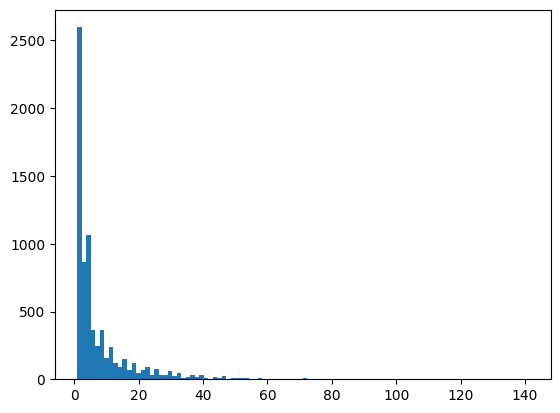

In [106]:
lens = [len(s.split()) for s in df['span'].to_list()]
bins = 100

print(np.min(lens), np.max(lens))
mu, sigma = np.mean(lens), np.std(lens)
print(mu, sigma)
plt.hist(lens, bins=bins)

# s = np.random.lognormal(mu, sigma, 1000)
# count, bins = np.histogram(lens, bins)
# x = np.linspace(min(bins), max(bins), 100)
# pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
#        / (x * sigma * np.sqrt(2 * np.pi)))
# plt.plot(x, pdf, linewidth=2, color='r')

plt.show()

In [33]:
df.sample(20)

,path,class,span
372,./dev_embeddings/article832948083_35.pt,NoClass,president .
2153,./dev_embeddings/article813547724_1.pt,Flag_Waving,Post-Brexit Britain should use its power to de...
844,./dev_embeddings/article832933796_3.pt,NoClass,happens next is “up to
2803,./dev_embeddings/article817408115_21.pt,Repetition,full and unfettered
3230,./dev_embeddings/article832940138_61.pt,NoClass,"Here's ISIS right now,” he said. The only prob..."
1880,./dev_embeddings/article832971448_30.pt,NoClass,"Barach Obama on a boat wearing a life vest, fr..."
992,./dev_embeddings/article833039623_73.pt,Flag_Waving,full-throated voice
2917,./dev_embeddings/article822942601_10.pt,Loaded_Language,near collapse
2964,./dev_embeddings/article822942601_57.pt,NoClass,"car crash, one that will forever command an ho..."
2099,./dev_embeddings/article813494037_7.pt,Flag_Waving,you are Londoners


## Training

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
data = pd.read_csv('train.csv')['class'].values.reshape(-1, 1)
onehot_encoder.fit(data)

class CustomDataset(Dataset):
    def __init__(self, csv_file, onehot_encoder, method='endpoint'):
        self.data = pd.read_csv(csv_file)
        self.labels = onehot_encoder.transform(self.data['class'].values.reshape(-1, 1))
        self.method = method

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_path = self.data.iloc[idx]['path']
        label = self.labels[idx]

        raw_embedding = torch.load(file_path)
        if self.method == 'endpoint':
            embedding = torch.cat((raw_embedding[:, 0, :], raw_embedding[:, -1, :]), dim=1)

        # return embedding, torch.LongTensor(label)
        return embedding, torch.tensor(label)
    
train_csv_path = 'train.csv'
test_csv_path = 'dev.csv'

train_dataset = CustomDataset(train_csv_path, onehot_encoder)
test_dataset = CustomDataset(test_csv_path, onehot_encoder)

train_batch_size = 128
test_batch_size = 128

train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

/tmp/ipykernel_7142/2052262480.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_dataset[0]

(tensor([[-0.1564,  0.0624,  0.2349,  ..., -0.0516,  0.0304, -0.0379]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.], dtype=torch.float64))

In [3]:
import torch.nn.functional as F
import torch.nn as nn

class CustomDeepClassifier(nn.Module):
    def __init__(self, input_dim=1536, num_classes=20, hidden_dim=2048):
        super(CustomDeepClassifier, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(1))

        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(1))

        layers.append(nn.Linear(hidden_dim, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = F.softmax(x, dim=0)
        return x

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_validate_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.1, stepslr=10, gamma=0.9):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, stepslr, gamma=gamma)

    train_losses = []
    val_losses = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for epoch in tqdm(range(num_epochs), total=num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        if (epoch + 1) % stepslr == 0:
            model.eval()
            running_val_loss = 0.0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())
                    loss = criterion(outputs.squeeze(), labels)
                    running_val_loss += loss.item()

                    predicted = torch.argmax(outputs.squeeze(1), 1)
                    labels = torch.argmax(labels, 1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_loss = running_val_loss / len(val_loader)
            val_losses.append(val_loss)

            precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

            scheduler.step()

            print(f"Epoch [{epoch + 1}/{num_epochs}] "
                f"Train Loss: {train_loss:.4f} "
                f"Val Loss: {val_loss:.4f} "
                f"Precision: {precision:.4f} "
                f"Recall: {recall:.4f} "
                f"F1 Score: {f1:.4f}\n")
            print(classification_report(all_labels, all_preds))

    return train_losses, val_losses, precision_scores, recall_scores, f1_scores


model = CustomDeepClassifier(input_dim=train_dataset[0][0].shape[1], num_classes=20)
train_losses, val_losses, precision_scores, recall_scores, f1_scores = train_validate_model(model,
                                                                                            train_data_loader,
                                                                                            test_data_loader,
                                                                                            num_epochs=500,
                                                                                            learning_rate=3e-4,
                                                                                            stepslr=50,
                                                                                            gamma=0.9)

 10%|█         | 50/500 [28:33<4:25:56, 35.46s/it]

Epoch [50/500] Train Loss: 2.9136 Val Loss: 2.9723 Precision: 0.1884 Recall: 0.1114 F1 Score: 0.0860

              precision    recall  f1-score   support

           0       0.04      0.10      0.05        21
           1       0.17      0.05      0.07       130
           2       0.00      0.29      0.01         7
           3       0.01      0.09      0.01        35
           4       0.02      0.05      0.03        20
           5       0.01      0.04      0.02        26
           6       0.36      0.08      0.13       183
           7       0.13      0.04      0.06       119
           8       0.28      0.20      0.23        61
           9       0.38      0.19      0.26        94
          10       0.00      0.25      0.01         4
          11       0.64      0.07      0.12       548
          12       0.57      0.11      0.18       285
          13       0.98      0.22      0.36      1801
          14       0.01      0.15      0.01        13
          15       0.00      0.00

 20%|██        | 100/500 [59:07<4:19:24, 38.91s/it]

Epoch [100/500] Train Loss: 2.9090 Val Loss: 2.9714 Precision: 0.1898 Recall: 0.1208 F1 Score: 0.1010

              precision    recall  f1-score   support

           0       0.07      0.29      0.11        21
           1       0.18      0.07      0.10       130
           2       0.00      0.14      0.01         7
           3       0.01      0.06      0.02        35
           4       0.02      0.05      0.03        20
           5       0.06      0.19      0.10        26
           6       0.44      0.09      0.15       183
           7       0.17      0.06      0.09       119
           8       0.19      0.16      0.18        61
           9       0.42      0.19      0.26        94
          10       0.00      0.00      0.00         4
          11       0.53      0.12      0.19       548
          12       0.48      0.08      0.13       285
          13       0.99      0.29      0.45      1801
          14       0.00      0.15      0.01        13
          15       0.01      0.1

 30%|███       | 150/500 [1:30:22<3:49:49, 39.40s/it]

Epoch [150/500] Train Loss: 2.9072 Val Loss: 2.9701 Precision: 0.2067 Recall: 0.1289 F1 Score: 0.1088

              precision    recall  f1-score   support

           0       0.02      0.14      0.04        21
           1       0.23      0.09      0.13       130
           2       0.00      0.00      0.00         7
           3       0.00      0.03      0.00        35
           4       0.03      0.10      0.05        20
           5       0.09      0.31      0.14        26
           6       0.41      0.10      0.16       183
           7       0.27      0.11      0.15       119
           8       0.11      0.16      0.13        61
           9       0.41      0.17      0.24        94
          10       0.00      0.25      0.01         4
          11       0.66      0.17      0.27       548
          12       0.61      0.08      0.14       285
          13       0.99      0.30      0.47      1801
          14       0.00      0.00      0.00        13
          15       0.01      0.1

 40%|████      | 200/500 [2:00:41<3:08:40, 37.73s/it]

Epoch [200/500] Train Loss: 2.9038 Val Loss: 2.9692 Precision: 0.1990 Recall: 0.1467 F1 Score: 0.1216

              precision    recall  f1-score   support

           0       0.04      0.19      0.06        21
           1       0.16      0.07      0.10       130
           2       0.00      0.00      0.00         7
           3       0.01      0.09      0.02        35
           4       0.03      0.15      0.05        20
           5       0.04      0.23      0.07        26
           6       0.49      0.21      0.29       183
           7       0.18      0.10      0.13       119
           8       0.12      0.23      0.16        61
           9       0.53      0.21      0.30        94
          10       0.00      0.25      0.01         4
          11       0.65      0.21      0.32       548
          12       0.62      0.14      0.23       285
          13       0.99      0.37      0.54      1801
          14       0.00      0.00      0.00        13
          15       0.00      0.0

 50%|█████     | 250/500 [2:31:46<2:38:10, 37.96s/it]

Epoch [250/500] Train Loss: 2.9033 Val Loss: 2.9688 Precision: 0.1998 Recall: 0.1629 F1 Score: 0.1328

              precision    recall  f1-score   support

           0       0.01      0.10      0.03        21
           1       0.19      0.11      0.14       130
           2       0.00      0.00      0.00         7
           3       0.01      0.06      0.02        35
           4       0.03      0.15      0.05        20
           5       0.02      0.12      0.03        26
           6       0.48      0.20      0.28       183
           7       0.19      0.12      0.14       119
           8       0.10      0.20      0.14        61
           9       0.38      0.26      0.30        94
          10       0.01      0.50      0.01         4
          11       0.68      0.23      0.34       548
          12       0.67      0.27      0.38       285
          13       0.99      0.42      0.59      1801
          14       0.00      0.00      0.00        13
          15       0.01      0.0

 60%|██████    | 300/500 [3:03:01<2:13:20, 40.00s/it]

Epoch [300/500] Train Loss: 2.9033 Val Loss: 2.9672 Precision: 0.2078 Recall: 0.2019 F1 Score: 0.1461

              precision    recall  f1-score   support

           0       0.03      0.14      0.04        21
           1       0.30      0.13      0.18       130
           2       0.00      0.14      0.01         7
           3       0.03      0.11      0.04        35
           4       0.03      0.15      0.06        20
           5       0.03      0.19      0.06        26
           6       0.50      0.23      0.32       183
           7       0.25      0.18      0.21       119
           8       0.11      0.28      0.16        61
           9       0.43      0.24      0.31        94
          10       0.01      0.75      0.03         4
          11       0.70      0.23      0.35       548
          12       0.61      0.24      0.34       285
          13       0.98      0.50      0.66      1801
          14       0.01      0.15      0.02        13
          15       0.01      0.0

 70%|███████   | 350/500 [3:33:35<1:34:54, 37.97s/it]

Epoch [350/500] Train Loss: 2.9020 Val Loss: 2.9672 Precision: 0.2109 Recall: 0.1663 F1 Score: 0.1479

              precision    recall  f1-score   support

           0       0.03      0.14      0.05        21
           1       0.19      0.10      0.13       130
           2       0.01      0.14      0.01         7
           3       0.01      0.03      0.01        35
           4       0.04      0.15      0.06        20
           5       0.04      0.19      0.07        26
           6       0.51      0.21      0.30       183
           7       0.18      0.11      0.14       119
           8       0.13      0.20      0.16        61
           9       0.48      0.29      0.36        94
          10       0.01      0.25      0.01         4
          11       0.66      0.28      0.39       548
          12       0.70      0.24      0.35       285
          13       0.98      0.51      0.67      1801
          14       0.01      0.08      0.01        13
          15       0.00      0.0

 80%|████████  | 400/500 [4:04:02<1:03:27, 38.07s/it]

Epoch [400/500] Train Loss: 2.9026 Val Loss: 2.9682 Precision: 0.2124 Recall: 0.1798 F1 Score: 0.1527

              precision    recall  f1-score   support

           0       0.01      0.10      0.03        21
           1       0.23      0.10      0.14       130
           2       0.00      0.00      0.00         7
           3       0.01      0.06      0.02        35
           4       0.03      0.10      0.05        20
           5       0.03      0.19      0.05        26
           6       0.54      0.21      0.31       183
           7       0.19      0.11      0.14       119
           8       0.22      0.25      0.23        61
           9       0.35      0.28      0.31        94
          10       0.01      0.50      0.02         4
          11       0.74      0.26      0.38       548
          12       0.63      0.28      0.38       285
          13       0.99      0.51      0.68      1801
          14       0.01      0.15      0.02        13
          15       0.00      0.0

 90%|█████████ | 450/500 [4:34:31<31:46, 38.13s/it]  

Epoch [450/500] Train Loss: 2.9021 Val Loss: 2.9686 Precision: 0.2038 Recall: 0.2304 F1 Score: 0.1555

              precision    recall  f1-score   support

           0       0.03      0.14      0.05        21
           1       0.29      0.15      0.19       130
           2       0.01      0.29      0.02         7
           3       0.03      0.11      0.04        35
           4       0.06      0.25      0.10        20
           5       0.01      0.08      0.02        26
           6       0.43      0.23      0.30       183
           7       0.19      0.12      0.15       119
           8       0.14      0.28      0.19        61
           9       0.42      0.22      0.29        94
          10       0.03      1.00      0.05         4
          11       0.64      0.33      0.44       548
          12       0.66      0.27      0.38       285
          13       0.97      0.57      0.72      1801
          14       0.01      0.08      0.01        13
          15       0.02      0.1

100%|██████████| 500/500 [5:06:13<00:00, 36.75s/it]

Epoch [500/500] Train Loss: 2.9012 Val Loss: 2.9674 Precision: 0.2100 Recall: 0.2139 F1 Score: 0.1577

              precision    recall  f1-score   support

           0       0.03      0.19      0.06        21
           1       0.32      0.11      0.16       130
           2       0.01      0.14      0.01         7
           3       0.01      0.11      0.03        35
           4       0.03      0.10      0.04        20
           5       0.04      0.15      0.06        26
           6       0.40      0.21      0.27       183
           7       0.19      0.13      0.15       119
           8       0.13      0.21      0.16        61
           9       0.41      0.23      0.30        94
          10       0.02      0.75      0.04         4
          11       0.67      0.31      0.43       548
          12       0.68      0.29      0.40       285
          13       0.97      0.60      0.74      1801
          14       0.02      0.23      0.03        13
          15       0.01      0.0

## Training with top 5 classes

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
data = pd.read_csv('train_top5.csv')['class'].values.reshape(-1, 1)
onehot_encoder.fit(data)

class CustomDataset(Dataset):
    def __init__(self, csv_file, onehot_encoder, method='endpoint'):
        self.data = pd.read_csv(csv_file)
        self.labels = onehot_encoder.transform(self.data['class'].values.reshape(-1, 1))
        self.method = method

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_path = self.data.iloc[idx]['path']
        label = self.labels[idx]

        raw_embedding = torch.load(file_path)
        if self.method == 'endpoint':
            embedding = torch.cat((raw_embedding[:, 0, :], raw_embedding[:, -1, :]), dim=1)

        # return embedding, torch.LongTensor(label)
        return embedding, torch.tensor(label)
    
train_csv_path = 'train_top5.csv'
test_csv_path = 'dev_top5.csv'

train_dataset = CustomDataset(train_csv_path, onehot_encoder)
test_dataset = CustomDataset(test_csv_path, onehot_encoder)

train_batch_size = 128
test_batch_size = 128

train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [24]:
train_dataset[0]

(tensor([[-0.1564,  0.0624,  0.2349,  ..., -0.0516,  0.0304, -0.0379]]),
 tensor([0., 0., 1., 0., 0., 0.], dtype=torch.float64))

In [25]:
import torch.nn.functional as F
import torch.nn as nn

class CustomDeepClassifier(nn.Module):
    def __init__(self, input_dim=1536, num_classes=20, hidden_dim=2048):
        super(CustomDeepClassifier, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(1))

        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(1))

        layers.append(nn.Linear(hidden_dim, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = F.softmax(x, dim=0)
        return x

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_validate_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.1, stepslr=10, gamma=0.9):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, stepslr, gamma=gamma)

    train_losses = []
    val_losses = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for epoch in tqdm(range(num_epochs), total=num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        if (epoch + 1) % stepslr == 0:
            model.eval()
            running_val_loss = 0.0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())
                    loss = criterion(outputs.squeeze(), labels)
                    running_val_loss += loss.item()

                    predicted = torch.argmax(outputs.squeeze(1), 1)
                    labels = torch.argmax(labels, 1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_loss = running_val_loss / len(val_loader)
            val_losses.append(val_loss)

            precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

            scheduler.step()

            print(f"Epoch [{epoch + 1}/{num_epochs}] "
                f"Train Loss: {train_loss:.4f} "
                f"Val Loss: {val_loss:.4f} "
                f"Precision: {precision:.4f} "
                f"Recall: {recall:.4f} "
                f"F1 Score: {f1:.4f}\n")
            print(classification_report(all_labels, all_preds))

    return train_losses, val_losses, precision_scores, recall_scores, f1_scores


model = CustomDeepClassifier(input_dim=train_dataset[0][0].shape[1], num_classes=6)
train_losses, val_losses, precision_scores, recall_scores, f1_scores = train_validate_model(model,
                                                                                            train_data_loader,
                                                                                            test_data_loader,
                                                                                            num_epochs=300,
                                                                                            learning_rate=3e-2,
                                                                                            stepslr=30,
                                                                                            gamma=0.5)

 10%|█         | 30/300 [16:30<2:33:15, 34.06s/it]

Epoch [30/300] Train Loss: 1.7608 Val Loss: 1.7755 Precision: 0.4430 Recall: 0.3735 F1 Score: 0.3966

              precision    recall  f1-score   support

           0       0.49      0.39      0.43       183
           1       0.20      0.14      0.17       119
           2       0.54      0.36      0.43       548
           3       0.52      0.28      0.36       285
           4       0.74      0.89      0.81      1801
           5       0.18      0.17      0.18       150

    accuracy                           0.65      3086
   macro avg       0.44      0.37      0.40      3086
weighted avg       0.62      0.65      0.62      3086



 20%|██        | 60/300 [32:10<2:09:13, 32.31s/it]

Epoch [60/300] Train Loss: 1.7600 Val Loss: 1.7770 Precision: 0.3903 Recall: 0.4088 F1 Score: 0.3941

              precision    recall  f1-score   support

           0       0.40      0.48      0.44       183
           1       0.14      0.23      0.18       119
           2       0.51      0.42      0.46       548
           3       0.33      0.33      0.33       285
           4       0.84      0.78      0.80      1801
           5       0.12      0.22      0.16       150

    accuracy                           0.61      3086
   macro avg       0.39      0.41      0.39      3086
weighted avg       0.64      0.61      0.62      3086



 30%|███       | 90/300 [47:43<1:53:03, 32.30s/it]

Epoch [90/300] Train Loss: 1.7589 Val Loss: 1.7752 Precision: 0.4044 Recall: 0.3985 F1 Score: 0.3853

              precision    recall  f1-score   support

           0       0.36      0.45      0.40       183
           1       0.19      0.17      0.18       119
           2       0.55      0.34      0.42       548
           3       0.40      0.28      0.33       285
           4       0.80      0.80      0.80      1801
           5       0.13      0.35      0.18       150

    accuracy                           0.60      3086
   macro avg       0.40      0.40      0.39      3086
weighted avg       0.64      0.60      0.61      3086



 40%|████      | 120/300 [1:03:18<1:37:08, 32.38s/it]

Epoch [120/300] Train Loss: 1.7577 Val Loss: 1.7743 Precision: 0.4208 Recall: 0.4237 F1 Score: 0.3975

              precision    recall  f1-score   support

           0       0.45      0.44      0.44       183
           1       0.15      0.22      0.17       119
           2       0.50      0.43      0.46       548
           3       0.42      0.29      0.34       285
           4       0.91      0.70      0.79      1801
           5       0.11      0.47      0.17       150

    accuracy                           0.57      3086
   macro avg       0.42      0.42      0.40      3086
weighted avg       0.69      0.57      0.62      3086



 50%|█████     | 150/300 [1:18:52<1:21:02, 32.42s/it]

Epoch [150/300] Train Loss: 1.7577 Val Loss: 1.7749 Precision: 0.4075 Recall: 0.3940 F1 Score: 0.3856

              precision    recall  f1-score   support

           0       0.41      0.33      0.36       183
           1       0.12      0.22      0.15       119
           2       0.52      0.49      0.51       548
           3       0.43      0.30      0.35       285
           4       0.89      0.74      0.80      1801
           5       0.09      0.29      0.13       150

    accuracy                           0.59      3086
   macro avg       0.41      0.39      0.39      3086
weighted avg       0.68      0.59      0.63      3086



 60%|██████    | 180/300 [1:34:27<1:04:53, 32.44s/it]

Epoch [180/300] Train Loss: 1.7572 Val Loss: 1.7767 Precision: 0.4004 Recall: 0.4246 F1 Score: 0.3981

              precision    recall  f1-score   support

           0       0.40      0.39      0.39       183
           1       0.13      0.25      0.17       119
           2       0.51      0.50      0.50       548
           3       0.34      0.38      0.36       285
           4       0.92      0.70      0.80      1801
           5       0.11      0.32      0.16       150

    accuracy                           0.58      3086
   macro avg       0.40      0.42      0.40      3086
weighted avg       0.69      0.58      0.62      3086



 70%|███████   | 210/300 [1:50:05<48:41, 32.46s/it]  

Epoch [210/300] Train Loss: 1.7568 Val Loss: 1.7754 Precision: 0.4078 Recall: 0.4291 F1 Score: 0.3951

              precision    recall  f1-score   support

           0       0.40      0.48      0.43       183
           1       0.13      0.17      0.15       119
           2       0.58      0.48      0.53       548
           3       0.32      0.38      0.35       285
           4       0.92      0.65      0.76      1801
           5       0.10      0.43      0.16       150

    accuracy                           0.55      3086
   macro avg       0.41      0.43      0.40      3086
weighted avg       0.70      0.55      0.61      3086



 80%|████████  | 240/300 [2:05:40<32:22, 32.37s/it]

Epoch [240/300] Train Loss: 1.7585 Val Loss: 1.7742 Precision: 0.4155 Recall: 0.3772 F1 Score: 0.3692

              precision    recall  f1-score   support

           0       0.43      0.25      0.32       183
           1       0.15      0.19      0.17       119
           2       0.59      0.37      0.46       548
           3       0.37      0.28      0.32       285
           4       0.87      0.76      0.81      1801
           5       0.09      0.41      0.14       150

    accuracy                           0.58      3086
   macro avg       0.42      0.38      0.37      3086
weighted avg       0.68      0.58      0.62      3086



 90%|█████████ | 270/300 [2:22:08<17:55, 35.83s/it]

Epoch [270/300] Train Loss: 1.7576 Val Loss: 1.7750 Precision: 0.4116 Recall: 0.4214 F1 Score: 0.3816

              precision    recall  f1-score   support

           0       0.38      0.52      0.44       183
           1       0.15      0.18      0.16       119
           2       0.57      0.28      0.37       548
           3       0.38      0.29      0.33       285
           4       0.89      0.74      0.81      1801
           5       0.11      0.52      0.18       150

    accuracy                           0.57      3086
   macro avg       0.41      0.42      0.38      3086
weighted avg       0.69      0.57      0.61      3086



100%|██████████| 300/300 [2:38:26<00:00, 31.69s/it]

Epoch [300/300] Train Loss: 1.7577 Val Loss: 1.7747 Precision: 0.4211 Recall: 0.4282 F1 Score: 0.3888

              precision    recall  f1-score   support

           0       0.38      0.54      0.44       183
           1       0.17      0.27      0.21       119
           2       0.56      0.32      0.41       548
           3       0.41      0.35      0.38       285
           4       0.93      0.64      0.76      1801
           5       0.08      0.45      0.14       150

    accuracy                           0.53      3086
   macro avg       0.42      0.43      0.39      3086
weighted avg       0.71      0.53      0.59      3086

